[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/indicium15/ml-workshop/blob/main/koh-et-al.ipynb)

# Install Dependencies
| Package      | Description                                   | Documentation Link |
|--------------|-----------------------------------------------|--------------------|
| openpyxl     | Read Excel Files | [openpyxl docs](https://openpyxl.readthedocs.io/en/stable/) |
| pandas       | Data analysis and manipulation library        | [pandas docs](https://pandas.pydata.org/docs/) |
| scikit-learn | Machine learning library for Python, including clustering algorithms | [scikit-learn docs](https://scikit-learn.org/stable/) |
| matplotlib   | 2D plotting library | [matplotlib docs](https://matplotlib.org/stable/) |
| seaborn      | Data visualization library | [seaborn docs](https://seaborn.pydata.org/) |
| gdown      | Package to download files from Google Drive | [gdown github](https://github.com/wkentaro/gdown) |


In [2]:
! pip install pandas openpyxl scikit-learn matplotlib seaborn gdown

# Download Data from Google Drive

In [3]:
import gdown
import os
# Make sure data folder exists
os.makedirs("data", exist_ok=True)
# Google Drive file ID
excel_file_id = "1WdmH2m00cUa0Uv1rtXvlkEfCXb2gL-OvJ1-9PL7saxU"
pdf_file_id = "1P1WA_88T_zjcrF13DijNs_zkjC8xOEWg"
# Download to data/ folder
gdown.download(id=excel_file_id, output="data/koh-et-al-2024-data.xlsx", quiet=True)
gdown.download(id=pdf_file_id, output="data/koh-et-al.pdf", quiet=True)

'data/koh-et-al.pdf'

# Data Loading
In the Excel File, the raw data is stored in the first sheet. Additionally, we must not read the information stored in:
1. Column A, as it contains the clustering results, and
2. Rows 57-60, as they are not relevant to the analysis.

Using Pandas `read_excel` function, which requires the python package `openpyxl`, we can easily load the data into memory. 

In [4]:
import pandas as pd

def load_vps_cluster_data(filepath="./data/koh-et-al-2024-data.xlsx"):
    """
    Loads and preprocesses the 'data_clustered_stats' sheet from the specified Excel file.

    - Reads only the 'data_clustered_stats' sheet
    - Skips the first column (column A)
    - Reads up to row 55
    
    Returns:
        pd.DataFrame: The cleaned dataframe
    """
    df = pd.read_excel(
        filepath,
        sheet_name="data_clustered_stats",
        nrows=55
    )
    # Filter out first column (index 0)
    df = df.iloc[:, 1:]
    return df

After calling the function to load the data, we can check the `shape` of the data, against our Excel sheet.

`shape` is represented as `(number of rows, number of columns)`.

We can also use the `.head()` function to inspect the first five rows of data.

In [5]:
df = load_vps_cluster_data()
print(df.shape)
df.head()

(54, 28)


,Use of first name,hustle,Scold,Silence,management,physical assistance,pre-instruction,pre-instruction Values,concurrent instructions,concurrent instructions Values,...,positive modelling values,uncodable,negative modeling values,positive modelling transfer,pre instruction transfer,post instruction transfer,concurrent instruction transfer,questioning transfer,negative modelling transfer,praise transfer
0,0,0,0,50,43,10,0,0,0,0,...,0.0,0,0,0,0,1,0,0,0,0
1,6,9,2,19,7,73,0,14,0,21,...,0.0,0,0,0,0,0,0,0,0,0
2,6,0,2,43,9,48,7,12,2,104,...,0.0,0,0,0,0,0,0,0,0,0
3,1,20,0,30,2,23,0,11,0,13,...,0.0,0,0,0,0,0,0,0,0,0
4,4,10,2,8,18,39,3,29,2,53,...,0.0,0,0,0,0,0,0,0,0,0


# Data Cleaning
An important part of data pre-processing is filtering out NaN (empty) cells. If not handled, they can cause errors in downstream machine learning tasks.

Thankfully, it is very easy to check for these values using the `isna()` method in Pandas, and find their locations.

In [6]:
# Check for NaN values and their locations and columns
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns[nan_columns].index.tolist())
nan_locations = df.isna().any(axis=1)
print("Rows with NaN values:")
print(df[nan_locations])

Columns with NaN values:
['post instructions', 'positive modelling values']
Rows with NaN values:
    Use of first name  hustle  Scold  Silence  management  \
15                  1       1      0       50           2   
42                  0       4      1       59           0   
49                 13      87      6        0          35   

    physical assistance  pre-instruction  pre-instruction Values  \
15                   22                7                       5   
42                   44               18                      14   
49                   29               39                      15   

    concurrent instructions  concurrent instructions Values  ...  \
15                        0                              23  ...   
42                        1                              22  ...   
49                        0                              39  ...   

    positive modelling values  uncodable  negative modeling values  \
15                        0.0          0 

In this case, we can safely assume that an empty cell reflects a zero value. Again, pandas makes this very easy with the `fillna()` function, and we can choose what value to fill the empty cells with as well.

In [7]:
# Fill NaN values with 0
df = df.fillna(0)

# Data Visualization
Pandas and Matplotlib are powerful tools for performing exploratory data analysis and visualizing results.

For example, here, with just a few lines of code, we can create histograms for each column and plot the results.

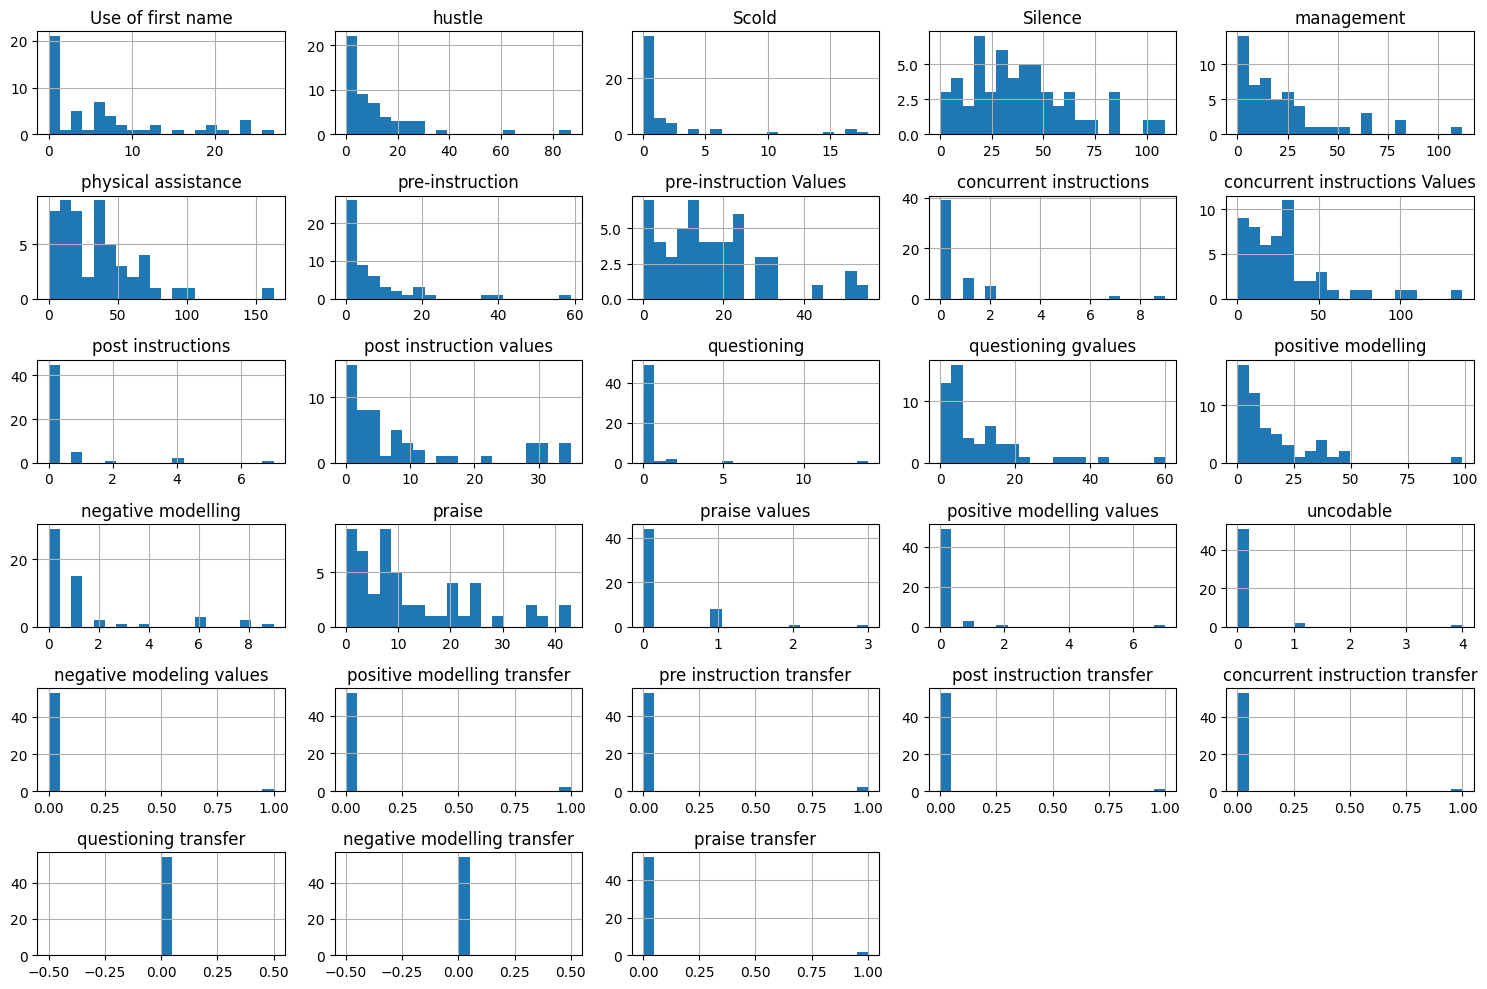

In [8]:
import matplotlib.pyplot as plt
# Create histograms for each column
df.hist(figsize=(15,10), bins=20)
# Visualize distributions for each column
plt.tight_layout()
plt.show()

# K-Means Clustering with Calinski–Harabasz Optimization

In this section, we:

1. Determine the optimal number of clusters (`k`) 
   - We run K-Means for a range of possible `k` values (default: 2–9).
   - For each `k`, we compute the **Calinski–Harabasz (CH) score**, which measures how well the data is separated into clusters (higher = better separation).
   - We plot the CH scores so you can visually inspect which `k` performs best.
   - The function prints and returns the `k` with the highest CH score.

2. Run K-Means clustering  
   - If `k` is not provided, we automatically select the best `k` using the CH score.
   - We fit K-Means to the dataset and assign each sample to a cluster.
   - The cluster labels are added as a new column (`Cluster`) in the DataFrame.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

def find_optimal_k(data, k_range=range(2, 10)):
    """
    Use Calinski-Harabasz score to find optimal number of clusters.
    """
    scores = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(data)
        score = calinski_harabasz_score(data, labels)
        scores.append(score)
    
    # Plot CH scores
    plt.plot(k_range, scores, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Calinski-Harabasz Score")
    plt.title("Optimal k via Calinski-Harabasz")
    plt.grid(True)
    plt.show()
    
    # Return best k
    best_k = k_range[scores.index(max(scores))]
    print(f"Optimal k based on CH score: {best_k}")
    return best_k

def cluster_vps_data(df, k=None):
    """
    Full pipeline: choose optimal k (if not given), cluster with KMeans.
    
    Returns:
        clustered_df: dataframe with cluster labels
        model: fitted KMeans model
    """
    if k is None:
        k = find_optimal_k(df)
    
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(df)
    
    clustered_df = df.copy()
    clustered_df['Cluster'] = labels
    
    return clustered_df, model

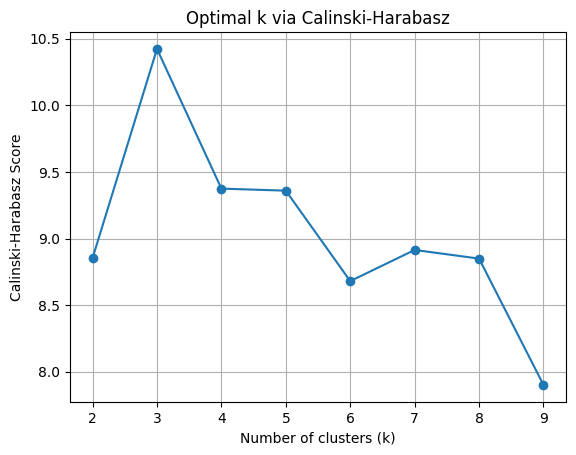

Optimal k based on CH score: 3
Cluster
0    31
1    12
2    11
Name: count, dtype: int64


In [10]:
clustered_df, kmeans_model = cluster_vps_data(df)
# View cluster sizes
print(clustered_df['Cluster'].value_counts())

# Visualize Clustering Results
After creating a new `Cluster` column in our DataFrame, we can summarize and visualize the characteristics of each cluster to understand how they differ.

### Group Data with `pandas.groupby`
- `groupby('Cluster')` groups the dataset by the cluster labels we assigned earlier.
- Using `.mean(numeric_only=True)` calculates the average value of each numeric feature for every cluster.
- Simlarly, `.std(numeric_only=True)` calculates the standard deviation of each feature for every cluster.

- These summaries are helpful for profiling clusters:  
  - High mean: feature is typical in that cluster.  
  - Low mean: feature is uncommon in that cluster.  
  - High std: feature usage varies widely between members of the cluster.  
  - Low std: feature usage is consistent in that cluster.

#### Why use Seaborn instead of Matplotlib?**
- Matplotlib is the core Python plotting library.
- Seaborn is built on top of Matplotlib and provides:
  - High-level functions for common statistical plots.
  - Better default styles and color palettes.
  - Built-in support for heatmaps, violin plots, pair plots, etc.
- `sns.heatmap()` makes it quick to visualize numeric tables (cluster means and standard deviations) as color-coded grids with optional annotations.

         Use of first name     hustle     Scold    Silence  management  \
Cluster                                                                  
0                 5.903226  10.193548  1.290323  48.612903   23.129032   
1                 9.916667   9.666667  4.750000  29.083333   22.666667   
2                 5.000000  17.000000  1.272727  22.909091   19.909091   

         physical assistance  pre-instruction  pre-instruction Values  \
Cluster                                                                 
0                  22.967742         4.258065               13.677419   
1                  79.666667        11.750000               22.333333   
2                  23.090909         8.818182               21.181818   

         concurrent instructions  concurrent instructions Values  ...  \
Cluster                                                           ...   
0                       0.193548                       16.225806  ...   
1                       1.166667            

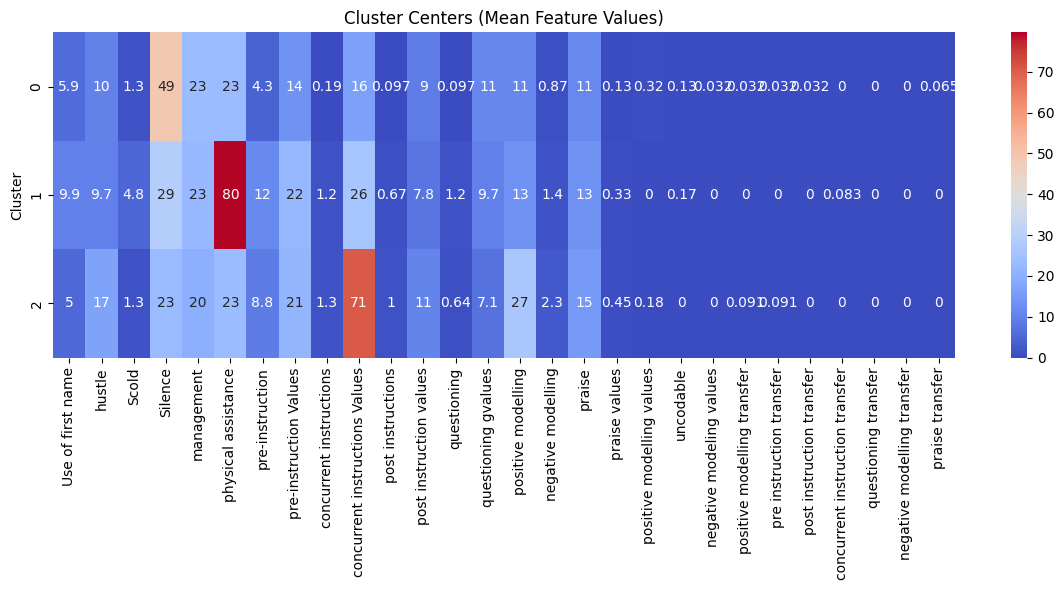

In [11]:
import seaborn as sns
# Calculate mean feature values for each cluster
cluster_means = clustered_df.groupby('Cluster').mean(numeric_only=True)
print(cluster_means)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Cluster Centers (Mean Feature Values)')
plt.tight_layout()
plt.show()

         Use of first name     hustle     Scold    Silence  management  \
Cluster                                                                  
0                 6.910643  13.300174  4.352727  24.498541   25.898188   
1                 8.371579  10.325021  6.047163  20.804101   23.503707   
2                 8.318654  25.223005  2.053821  19.679708   21.524194   

         physical assistance  pre-instruction  pre-instruction Values  \
Cluster                                                                 
0                  14.718433         8.082771                9.239001   
1                  29.684196        16.102654               16.740443   
2                  16.379588        11.965101               16.714175   

         concurrent instructions  concurrent instructions Values  ...  \
Cluster                                                           ...   
0                       0.477448                       11.904368  ...   
1                       2.552479            

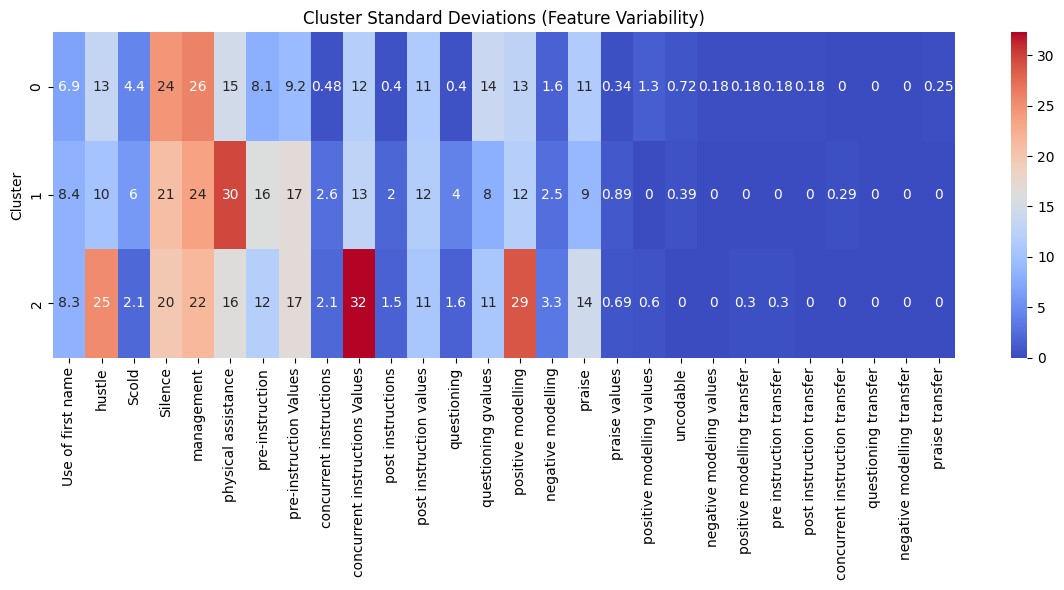

In [12]:
# Calculate standard deviation of feature values for each cluster
cluster_stds = clustered_df.groupby('Cluster').std(numeric_only=True)
print(cluster_stds)

# Plot heatmap of standard deviations
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stds, annot=True, cmap='coolwarm')
plt.title('Cluster Standard Deviations (Feature Variability)')
plt.tight_layout()
plt.show()

Chosen k: 3
Cluster sizes:
Cluster
0    31
1    12
2    11
Name: count, dtype: int64 

Cluster means (first 5 columns):
         Use of first name     hustle     Scold    Silence  management
Cluster                                                               
0                 5.903226  10.193548  1.290323  48.612903   23.129032
1                 9.916667   9.666667  4.750000  29.083333   22.666667
2                 5.000000  17.000000  1.272727  22.909091   19.909091


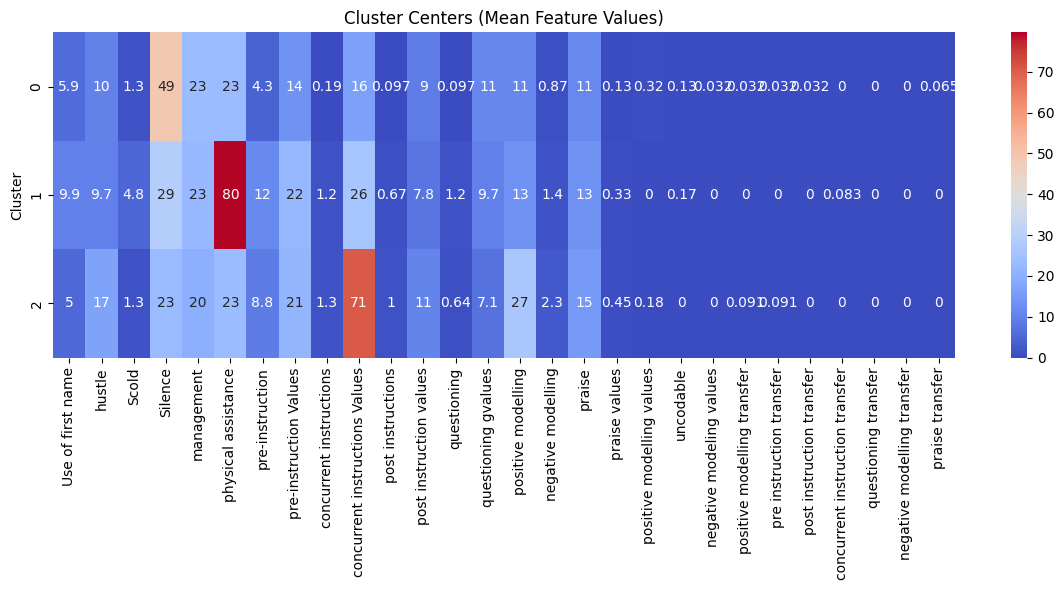


Cluster standard deviations (first 5 columns):
         Use of first name     hustle     Scold    Silence  management
Cluster                                                               
0                 6.910643  13.300174  4.352727  24.498541   25.898188
1                 8.371579  10.325021  6.047163  20.804101   23.503707
2                 8.318654  25.223005  2.053821  19.679708   21.524194


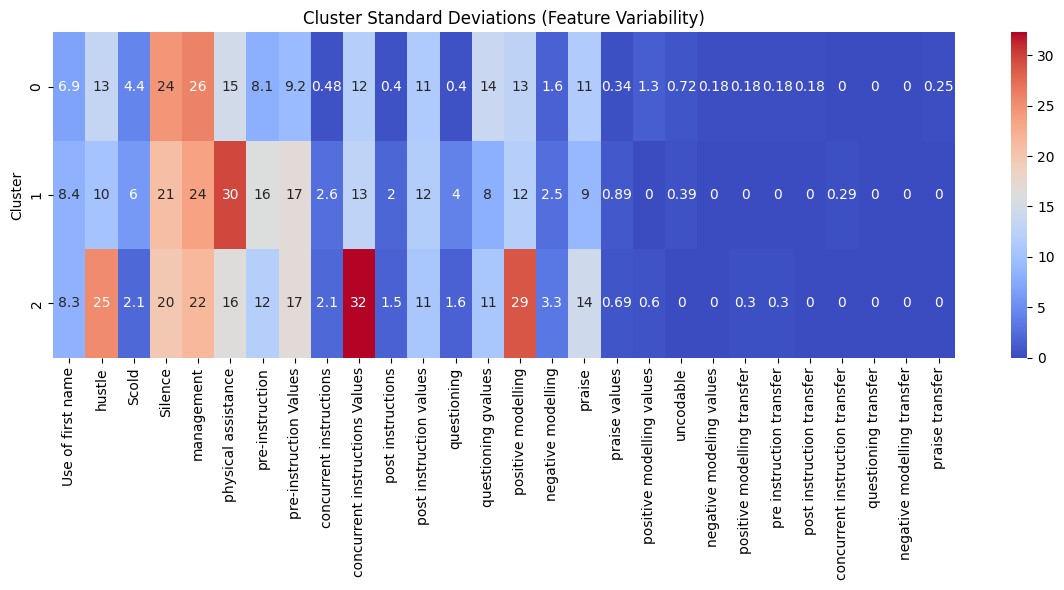

In [ ]:
#@title Try it yourself: K-Means with selectable k {display-mode: "form"}
#@markdown Choose the number of clusters **k**, optionally normalize features to 0–1, and then press the run button on the left of the cell.
k = 3  #@param {type:"slider", min:2, max:12, step:1}
normalize_01 = True  #@param {type:"boolean"}

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional normalization
if normalize_01:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df)

# Run clustering with selected k
clustered_df, kmeans_model = cluster_vps_data(df, k)

# View cluster sizes
print(f"Chosen k: {k}")
print("Cluster sizes:")
print(clustered_df['Cluster'].value_counts().sort_index(), "\n")

# Calculate means and stds
cluster_means = clustered_df.groupby('Cluster').mean(numeric_only=True)
cluster_stds = clustered_df.groupby('Cluster').std(numeric_only=True)

# Plot cluster centers (means)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Cluster Centers (Mean Feature Values)')
plt.tight_layout()
plt.show()

# Plot cluster standard deviations
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stds, annot=True, cmap='coolwarm')
plt.title('Cluster Standard Deviations (Feature Variability)')
plt.tight_layout()
plt.show()
